In [1]:
import pandas as pd
import re
import os

In [2]:
train = pd.read_csv('MentalLLaMA/train_data/complete_data/combined/train.csv')
val = pd.read_csv('MentalLLaMA/train_data/complete_data/combined/val.csv')

train.head()

,post,question,response
0,Post: How to avoid a relapse? I've been having...,"Question: The answer to the question ""Does th...",yes. Reasoning: The post displays a significan...
1,Post: This is how I feel and I have a slight s...,"Question: The answer to the question ""Does th...",yes. Reasoning: The post exhibits a clear and ...
2,Post: Advice for getting back in touch with ev...,"Question: The answer to the question ""Does th...",yes. Reasoning: The post conveys a sense of di...
3,Post: Having a really bad stretch of days.. Hi...,"Question: The answer to the question ""Does th...",yes. Reasoning: The post expresses a deep sens...
4,Post: I dont understand how people can be so i...,"Question: The answer to the question ""Does th...",yes. Reasoning: The post expresses a lack of i...


In [3]:
import re
import pandas as pd

def clean_mental_health_df(df):
    """
    Cleans prefixes and extracts labels from a mental health-related DataFrame.
    
    Assumes columns: 'post', 'question', 'response'
    Adds a new column: 'label'
    """
    df = df.copy()
    df['label'] = df['response'].str.extract(r'^\s*(yes|no)', flags=re.IGNORECASE)[0].str.lower()
    # Remove prefixes
    df['post'] = df['post'].str.replace(r'^Post:\s*', '', regex=True)
    df['question'] = df['question'].str.extract(r'"(.*?)"', expand=False)
    df['condition'] = df['question'].str.lower().apply(
            lambda x: 'stress' if 'stress' in x else ('depression' if 'depression' in x else None)
        )
    df.loc[df['label'] == 'no', 'condition'] = 'none'
    df['response'] = df['response'].str.replace(r'^\s*(yes|no)[\.:]?\s*Reasoning:\s*', '', flags=re.IGNORECASE, regex=True)

    # Extract labels
    

    return df[['post','condition','response']]
train_processed = clean_mental_health_df(train)
val_processed = clean_mental_health_df(val)

In [4]:
train_processed

,post,condition,response
0,How to avoid a relapse? I've been having a par...,depression,The post displays a significant amount of emot...
1,This is how I feel and I have a slight sense I...,depression,The post exhibits a clear and profound sense o...
2,Advice for getting back in touch with everyday...,depression,The post conveys a sense of disengagement and ...
3,"Having a really bad stretch of days.. Hi all, ...",depression,The post expresses a deep sense of emotional p...
4,I dont understand how people can be so interes...,depression,The post expresses a lack of interest and enjo...
...,...,...,...
3835,But then I'll get there and he'll drop the bom...,stress,The poster expresses frustration and annoyance...
3836,"* Her, a week ago: Precious, how are you? (I i...",none,The language used in this post does not indica...
3837,I don't have the ability to cope with it anymo...,stress,The language used in this post indicates a hig...
3838,In case this is the first time you're reading ...,none,The post does not indicate any emotional distr...


In [7]:
val_processed

,post,condition,response
0,I'm finally dead inside and I don't know how t...,depression,The post strongly indicates that the poster is...
1,what's it like coming off anti-depressants? I ...,depression,The post expresses concern and curiosity about...
2,"I really need help making friends I'm 25, livi...",depression,"The post conveys a sense of loneliness, isolat..."
3,So dramatic 😪 My best friend and I were in the...,none,The post does not exhibit strong emotional ind...
4,My dad's mad after game night. My family and I...,none,The post does not exhibit strong emotional ind...
...,...,...,...
725,I'm completely overwhelmed. I think this proce...,stress,The poster expresses feeling overwhelmed and u...
726,"Hey everyone, I’ve had quite the journey the l...",none,The poster does mention past trauma and health...
727,I'm 14 years old going in highschool. I've had...,stress,The poster explicitly mentions suffering from ...
728,"He loved to learn, he said. I felt his hope. B...",none,The poster's language in this post is positive...


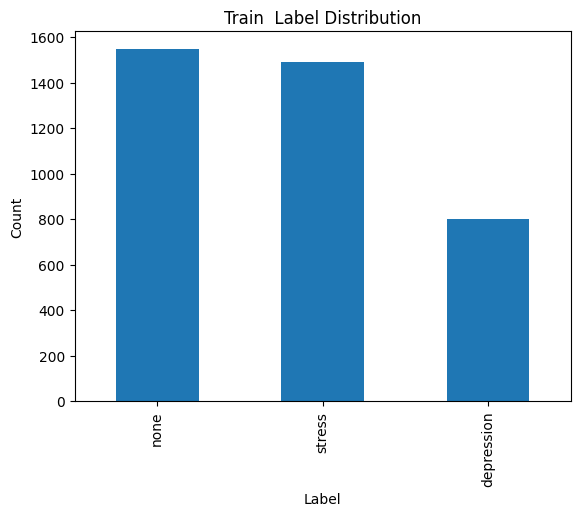

In [6]:
import matplotlib.pyplot as plt

# Plot original label distribution
train_processed['condition'].value_counts().plot(kind='bar')
plt.title('Train  Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

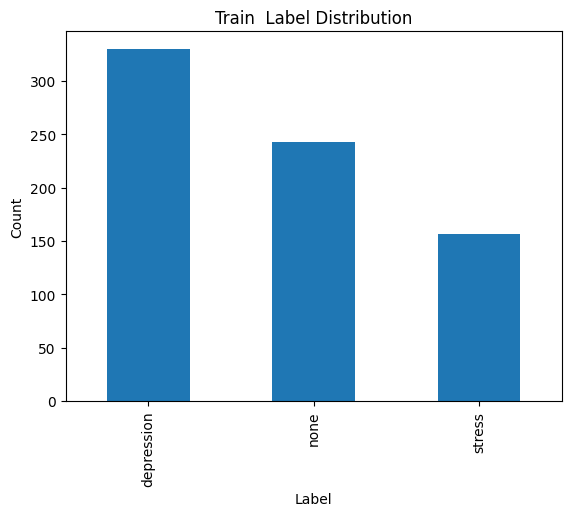

In [8]:
import matplotlib.pyplot as plt

# Plot original label distribution
val_processed['condition'].value_counts().plot(kind='bar')
plt.title('Train  Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [9]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import TfidfVectorizer

def select_diverse_clean_data(df, k=50, model_name="gpt2"):
    """
    Select k diverse (post, response) pairs from a DataFrame using:
    - Perplexity filtering (removes outliers)
    - TF-IDF vectorization
    - K-Center Greedy for diversity

    Args:
        df (pd.DataFrame): Input DataFrame with 'post' and 'response' columns.
        k (int): Number of diverse examples to select.
        model_name (str): HuggingFace model to compute perplexity with.

    Returns:
        pd.DataFrame: Selected diverse subset.
    """

    # Step 1: Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    model.eval()

    # Step 2: Compute perplexity for each (post, response) pair
    def compute_perplexity(instruction, output):
        text = instruction + " " + output
        text = text[:tokenizer.model_max_length]
        encodings = tokenizer(text, return_tensors="pt")
        with torch.no_grad():
            logits = model(**encodings).logits
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = encodings.input_ids[:, 1:].contiguous()
        loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        return torch.exp(loss.mean()).item()

    data_pairs = list(zip(df['post'], df['response']))
    perplexities = np.array([compute_perplexity(x, y) for x, y in data_pairs])

    # Step 3: Filter outliers using IQR
    Q1 = np.percentile(perplexities, 25)
    Q3 = np.percentile(perplexities, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_indices = np.where((perplexities >= lower_bound) & (perplexities <= upper_bound))[0]
    filtered_data = [data_pairs[i] for i in filtered_indices]

    # Step 4: TF-IDF vectorization
    text_data = [" ".join(pair) for pair in filtered_data]
    vectorizer = TfidfVectorizer()
    vector_embeddings = vectorizer.fit_transform(text_data).toarray()

    # Step 5: K-Center Greedy
    def k_center_greedy(data_vectors, k):
        selected_indices = [np.random.randint(len(data_vectors))]
        for _ in range(k - 1):
            remaining = np.delete(data_vectors, selected_indices, axis=0)
            distances = cdist([data_vectors[i] for i in selected_indices], remaining, metric="euclidean").min(axis=0)
            new_center = np.argmax(distances)
            new_center_index = [i for i in range(len(data_vectors)) if i not in selected_indices][new_center]
            selected_indices.append(new_center_index)
        return selected_indices

    # Step 6: Select diverse samples
    k = min(k, len(vector_embeddings))  # prevent out-of-range
    selected_indices = k_center_greedy(vector_embeddings, k)
    final_selected_data = [filtered_data[i] for i in selected_indices]

    # Step 7: Return as DataFrame
    return pd.DataFrame(final_selected_data, columns=['post', 'response'])


d:\anaconda\envs\LLM_app\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
train_filled = select_diverse_clean_data(train_processed, k=1800)
len(train_filled)
# Example: Filter A where ['id', 'name'] matches B
train_filled = train_processed.merge(train_filled, on=['post', 'response'], how='inner')


KeyboardInterrupt: 

In [63]:
val_filled = select_diverse_clean_data(val_processed, k=400)
len(val_filled)
# Example: Filter A where ['id', 'name'] matches B
val_filled = val_processed.merge(val_filled, on=['post', 'response'], how='inner')


In [58]:
train_filled['condition'].value_counts().plot(kind='bar')
plt.title('Original Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

500

In [62]:

train_filled.to_csv('train_filled.csv', index=False)
val_filled.to_csv('val_filled.csv', index=False)

Text(0, 0.5, 'Count')

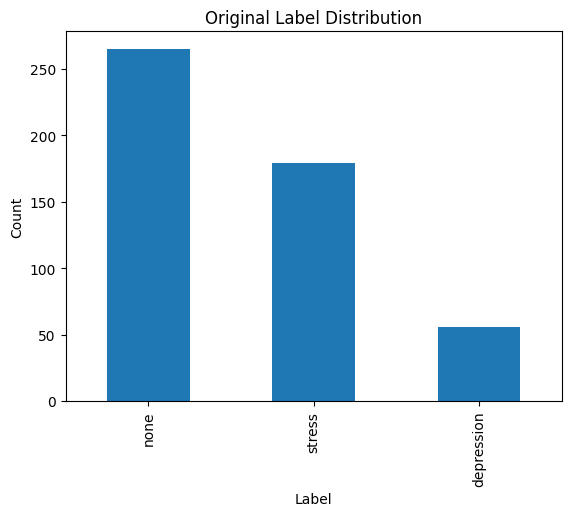

In [ ]:
#Split data

import math
# Load your dataset
df =train_filled  # Replace with your actual file name

# Define name prefixes
name_prefixes = [
    "Linh_Chu",
    "Đuc_Thinh_Nguyễn",
    "Tien_To_Hoang_Minh",
    "Victor",
    "Kim_Trang_Vo_Thi"
]

# Calculate rows per file
num_parts = len(name_prefixes)
rows_per_file = math.ceil(len(df) / num_parts)

# Split and save
for i, prefix in enumerate(name_prefixes):
    start = i * rows_per_file
    end = start + rows_per_file
    df_part = df.iloc[start:end]
    
    filename = f"{prefix}_data_part_{i+1}.csv".replace(" ", "_")  # Optional: replace spaces for safety
    df_part.to_csv(filename, index=False)




In [ ]:
#Split data

import math
# Load your dataset
df =val_filled  # Replace with your actual file name

# Define name prefixes
name_prefixes = [
    "Nguyen_Tran",
    "Nguyen_Minh_Chi"
]

# Calculate rows per file
num_parts = len(name_prefixes)
rows_per_file = math.ceil(len(df) / num_parts)

# Split and save
for i, prefix in enumerate(name_prefixes):
    start = i * rows_per_file
    end = start + rows_per_file
    df_part = df.iloc[start:end]
    
    filename = f"{prefix}_data_part_{i+1}.csv".replace(" ", "_")  # Optional: replace spaces for safety
    df_part.to_csv(filename, index=False)


